### Visualising a slice of the 3D CT scan and mask- Sample 1

CT scan shape: (512, 512, 82)
Mask shape: (512, 512, 82)


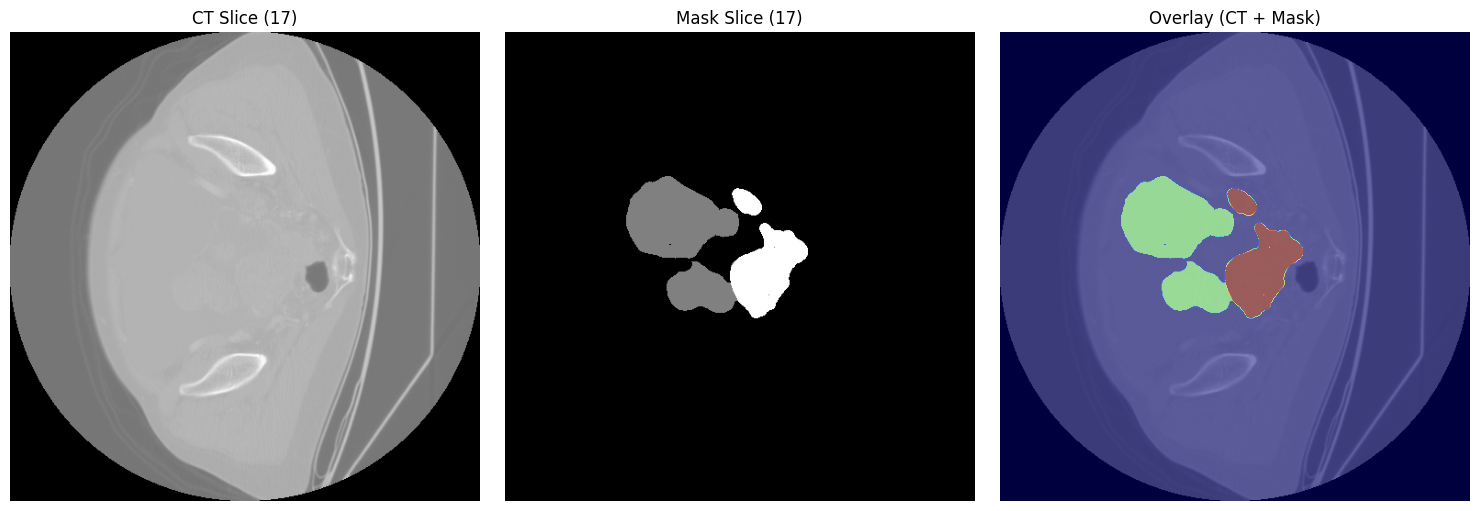

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Load the CT scan and mask
test_load = nib.load('/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/TCGA/TCGA-09-0367.nii').get_fdata()
mask_load = nib.load('/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/segmentation/TCGA-09-0367.nii').get_fdata()

print("CT scan shape:", test_load.shape)
print("Mask shape:", mask_load.shape)

# Select the same slice for both CT and mask 
ct_slice = test_load[:, :, 17]  # CT slice
mask_slice = mask_load[:, :, 17]  # Corresponding mask slice (same slice number)

# Create a figure with 3 subplots side by side
plt.figure(figsize=(15, 5))

# Plot CT slice
plt.subplot(1, 3, 1)
plt.imshow(ct_slice, cmap='gray')
plt.title('CT Slice (17)')
plt.axis('off')

# Plot Mask slice
plt.subplot(1, 3, 2)
plt.imshow(mask_slice, cmap='gray')
plt.title('Mask Slice (17)')
plt.axis('off')

# Plot Overlay (CT + Mask)
plt.subplot(1, 3, 3)
plt.imshow(ct_slice, cmap='gray')  # CT as background
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # Mask overlay with transparency
plt.title('Overlay (CT + Mask)')
plt.axis('off')

plt.tight_layout()
plt.savefig('/kaggle/working/ct_mask_overlay.png', dpi=300, bbox_inches='tight')  # Saves as PNG

plt.show()


### Visualising a slice of the 3D CT scan and mask- Sample 2

CT scan shape: (512, 512, 82)
Mask shape: (512, 512, 82)


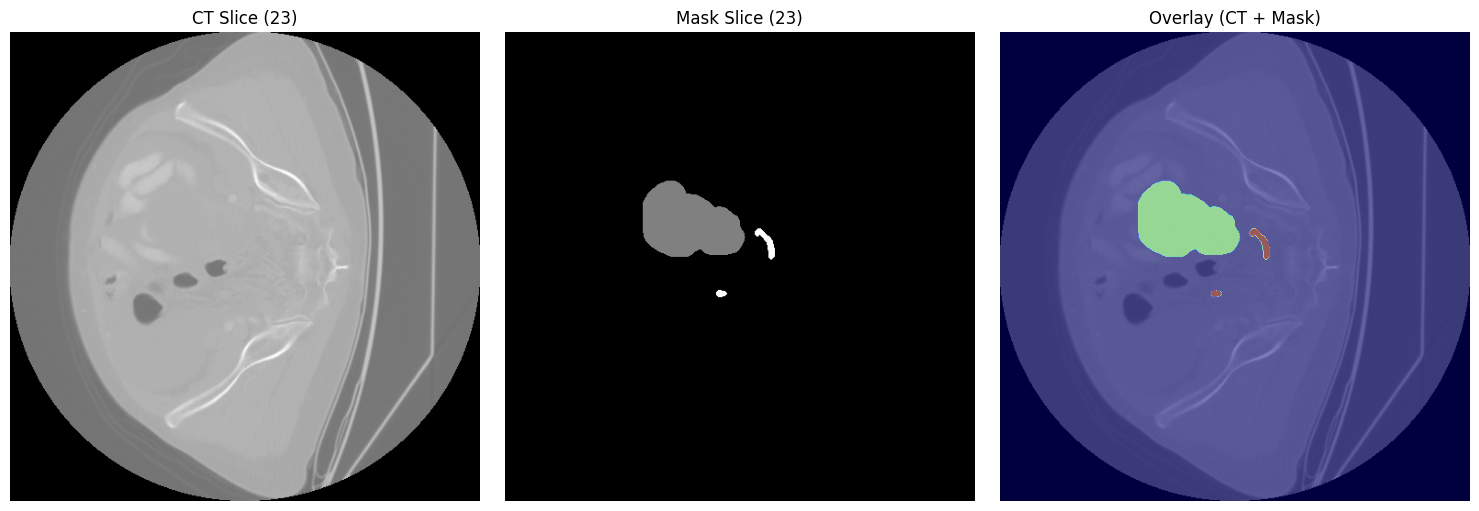

<Figure size 640x480 with 0 Axes>

In [ ]:
# Load the CT scan and mask
test_load = nib.load('/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/TCGA/TCGA-09-0367.nii').get_fdata()
mask_load = nib.load('/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/segmentation/TCGA-09-0367.nii').get_fdata()

print("CT scan shape:", test_load.shape)
print("Mask shape:", mask_load.shape)

# Select the same slice for both CT and mask 
ct_slice = test_load[:, :, 23]  # CT slice
mask_slice = mask_load[:, :, 23]  # Corresponding mask slice (same slice number)

# Create a figure with 3 subplots side by side
plt.figure(figsize=(15, 5))

# Plot CT slice
plt.subplot(1, 3, 1)
plt.imshow(ct_slice, cmap='gray')
plt.title('CT Slice (23)')
plt.axis('off')

# Plot Mask slice
plt.subplot(1, 3, 2)
plt.imshow(mask_slice, cmap='gray')
plt.title('Mask Slice (23)')
plt.axis('off')

# Plot Overlay (CT + Mask)
plt.subplot(1, 3, 3)
plt.imshow(ct_slice, cmap='gray')  # CT as background
plt.imshow(mask_slice, cmap='jet', alpha=0.5)  # Mask overlay with transparency
plt.title('Overlay (CT + Mask)')
plt.axis('off')

plt.tight_layout()
plt.show()
plt.savefig('/kaggle/working/ct_mask_overlay2.png', dpi=300, bbox_inches='tight')  # Saves as PNG


In [ ]:
# Print pixel values in CT scam
# print(np.unique(mask_load))
# print(np.unique(test_load))
print(test_load.max())
print(test_load.min())

1546.0
-3023.0


In [ ]:
# Set directories
ct_dir = '/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/TCGA'
seg_dir = '/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/segmentation'
output_dir = '/kaggle/working/slices'
slice_dir = '/kaggle/working/text'


# Create output and slices directories
os.makedirs(output_dir, exist_ok=True)
os.makedirs(slice_dir, exist_ok=True)



### Data Preprocessing and Extraction

In [ ]:
def preprocess(ct_path, seg_path, case_id):
    """Process a single CT volume and its segmentation"""
    # Load volumes
    image = nib.load(ct_path).get_fdata()
    mask = nib.load(seg_path).get_fdata()

    # Find annotated slices
    annotated_slices = []
    for slice_idx in range(mask.shape[2]):
        if np.any(mask[:, :, slice_idx] > 0):
            annotated_slices.append(slice_idx)
    
    print(f"Processing {case_id}: Found {len(annotated_slices)} annotated slices")
    
    # Process each annotated slice
    for slice_idx in annotated_slices:
        # Get CT slice and normalize
        image_slice = image[:, :, slice_idx]
        mask_slice = mask[:, :, slice_idx]
        normalized_slice = normalize(image_slice.reshape(1, -1)).reshape(image_slice.shape)
        
        # Save as PNG
        output_path = os.path.join(output_dir, f"{case_id}_slice_{slice_idx:03d}.png")
        plt.imsave(output_path, normalized_slice, cmap='gray')
        print(f"Saved {output_path}")

        # Prepare YOLO labels
        text_path = os.path.join(slice_dir, f"{case_id}_slice_{slice_idx:03d}.txt")
        with open(text_path, "w") as f:  # Open in WRITE mode (clears old content)
            class_ids = {1: 0, 2: 1}  # Pixel value → YOLO class ID
            
            for class_id, yolo_id in class_ids.items():
                class_mask = (mask_slice == class_id).astype(np.uint8)
                if np.any(class_mask):
                    contours, _ = cv2.findContours(
                        class_mask * 255, 
                        cv2.RETR_EXTERNAL, 
                        cv2.CHAIN_APPROX_SIMPLE
                    )
                    for cnt in contours:
                        if cv2.contourArea(cnt) >= 1:
                            # Extract and normalize points
                            points = cnt.squeeze()
                            if points.ndim == 1 or len(points) < 3:
                                continue  # Skip invalid polygons
                            
                            polygon = " ".join([
                                f"{x/mask_slice.shape[1]:.6f} {y/mask_slice.shape[0]:.6f}"
                                for x, y in points
                            ])
                            f.write(f"{yolo_id} {polygon}\n")  # Append each polygon
        print(f"Saved labels: {text_path}")

In [ ]:
from sklearn.preprocessing import normalize
import os

# Get all CT and segmentation files
ct_files = [f for f in os.listdir(ct_dir) if f.endswith('.nii')]
seg_files = [f for f in os.listdir(seg_dir) if f.endswith('.nii')]
slice_files = [f for f in os.listdir(slice_dir)]


# Process each case
for ct_file in ct_files:
    case_id = ct_file.split('.')[0]  # Extract case ID (e.g., 'TCGA-09-0367')
    matching_seg = next((f for f in seg_files if f.startswith(case_id)), None)
    
    if matching_seg:
        ct_path = os.path.join(ct_dir, ct_file)
        seg_path = os.path.join(seg_dir, matching_seg)
        preprocess(ct_path, seg_path, case_id)
    else:
        print(f"No matching segmentation found for {ct_file}")

print("Processing complete!")

#### For verification purposes

Found 4 contours with areas: [7655.0, 616.5, 7226.5, 4.0]


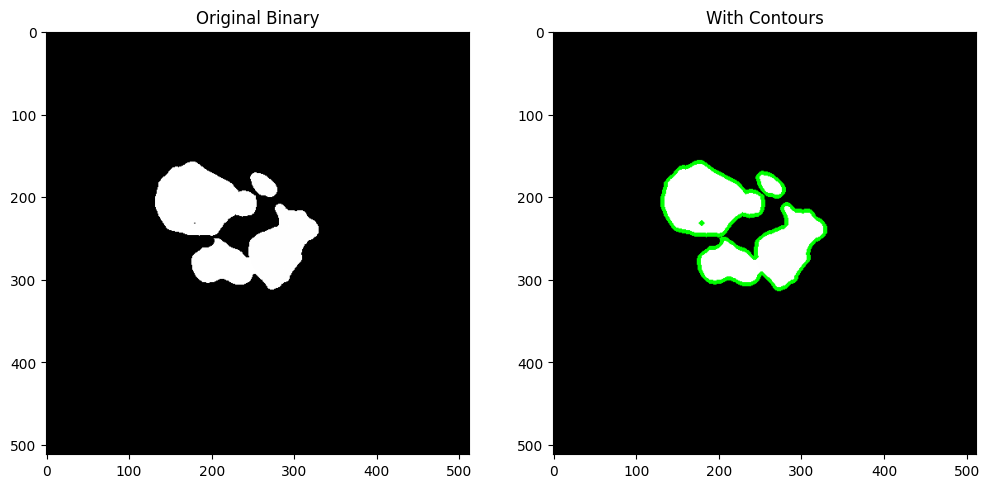

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
mask_load = nib.load('/kaggle/input/ml-dataset-assignment3/ML DataSet Assignment3/segmentation/TCGA-09-0367.nii').get_fdata()

# 1. Prepare the image properly
slice_9 = mask_load[:,:,17]
binary_slice = (slice_9 * 255).astype(np.uint8)  # Convert to 8-bit

# 2. Create a copy for drawing contours
contour_img = cv2.cvtColor(binary_slice, cv2.COLOR_GRAY2BGR)  # Must be 3-channel for color contours

# 3. Find contours
contours, hierarchy = cv2.findContours(binary_slice, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(f"Found {len(contours)} contours with areas: {[cv2.contourArea(c) for c in contours]}")

# 4. Draw contours (green with thickness 3)
cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 3)

# 5. Display results
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(binary_slice, cmap='gray'), plt.title('Original Binary')
plt.subplot(122), plt.imshow(contour_img), plt.title('With Contours')
# Save the figure
plt.savefig('/kaggle/working/segmentation mask and contour.png', dpi=300, bbox_inches='tight')  # Saves as PNG
plt.show()

# # Alternative OpenCV display
# cv2.imshow('Contour Visualization', contour_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

### Data Organization

Format required
datasets/images/ and datasets/labels/

    ├── datasets/ 
    │   ├── images/
    │   │   ├── train/
    │   │   ├── val/
    │   │   └── test/
    │   └── labels/
    │       ├── train/
    │       ├── val/
    │       └── test/

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths
dataset_dir = "dataset"
images_dir = os.path.join(dataset_dir, "images")
labels_dir = os.path.join(dataset_dir, "labels")

# Create folders
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(images_dir, split), exist_ok=True)
    os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

# List all PNG slices and split (80% train, 10% val, 10% test)
all_images = [f for f in os.listdir("/kaggle/working/slices") if f.endswith(".png")]
train, test = train_test_split(all_images, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)

# Move files to YOLOv8 structure
def copy_files(files, split):
    for f in files:
        # Move image
        shutil.copy(
            os.path.join("/kaggle/working/slices", f),
            os.path.join(images_dir, split, f)
        )
        # Move corresponding label
        label_file = f.replace(".png", ".txt")
        shutil.copy(
            os.path.join("/kaggle/working/text", label_file),
            os.path.join(labels_dir, split, label_file)
        )

copy_files(train, "train")
copy_files(val, "val")
copy_files(test, "test")

In [ ]:
import torch
print(f"GPU Available: {torch.cuda.is_available()}")
print(f"GPU Name: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

GPU Available: True
GPU Name: Tesla T4


In [ ]:
import torch
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi  

Fri Apr 25 17:55:38 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 6. Train YOLO11 segmentation model

In [ ]:
# Install the required packages for YOLO11 and Comet ML
!pip install ultralytics comet_ml torch torchvision

In [ ]:
import comet_ml

comet_ml.login(project_name="comet-tumorsegmentation-yolo11")

In [ ]:
from ultralytics import YOLO
# Load a model
model = YOLO("yolo11n-seg.pt")  # load a pretrained model 
model.to('cuda')  # Force GPU usage
# Train the model
results = model.train(data="/kaggle/input/datasett-yaml/dataset.yaml", 
                      project="comet-tumorsegmentation-yolo11",
                      epochs=100, 
                      imgsz=512, 
                      batch=16, 
                      verbose=True)

engine/trainer: task=segment, mode=train, model=yolo11n-seg.pt, data=/kaggle/input/datasett-yaml/dataset.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=comet-tumorsegmentation-yolo11, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=Fa

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/oluwajobaoluwabori/comet-tumorsegmentation-yolo11/cad7db19626341a5821d19a86e801cc0

COMET INFO: Couldn't find a Git repository in '/kaggle/working' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 272.1±144.9 MB/s, size: 119.8 KB)


train: Scanning /kaggle/input/dataset/dataset/labels/train... 1515 images, 14 backgrounds, 0 corrupt: 100%|██████████| 1515/1515 [00:02<00:00, 740.32it/s]

WARNING ⚠️ train: Cache directory /kaggle/input/dataset/dataset/labels is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 122.3±90.5 MB/s, size: 86.1 KB)


val: Scanning /kaggle/input/dataset/dataset/labels/val... 189 images, 3 backgrounds, 0 corrupt: 100%|██████████| 189/189 [00:00<00:00, 567.21it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/dataset/dataset/labels is not writeable, cache not saved.


Plotting labels to comet-tumorsegmentation-yolo11/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 90 weight(decay=0.0), 101 weight(decay=0.0005), 100 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to comet-tumorsegmentation-yolo11/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.78G      2.606       4.28      4.397      1.883         31        512: 100%|██████████| 95/95 [00:21<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.74it/s]

                   all        189        391      0.333     0.0277     0.0556     0.0229      0.344     0.0262     0.0595     0.0221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.2G       2.38      3.789      3.474      1.694         20        512: 100%|██████████| 95/95 [00:19<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all        189        391      0.223     0.0552     0.0538     0.0185      0.188     0.0466     0.0437      0.016



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100       2.2G       2.35      3.675      3.091      1.645         42        512: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.36it/s]

                   all        189        391      0.477     0.0394     0.0533     0.0239      0.159     0.0154     0.0188    0.00765



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100       2.2G      2.218      3.537      2.821       1.61         25        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.14it/s]

                   all        189        391      0.115      0.101     0.0552     0.0215      0.113      0.099      0.055     0.0207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100       2.2G      2.216       3.52      2.725      1.581         24        512: 100%|██████████| 95/95 [00:19<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        189        391      0.279      0.097     0.0854     0.0363      0.338      0.104     0.0893     0.0297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100       2.2G      2.157      3.483      2.643      1.519         44        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        189        391      0.486      0.156      0.167     0.0856       0.55      0.146      0.153      0.078



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.2G      2.136      3.441       2.55      1.534         19        512: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        189        391      0.278      0.194      0.151     0.0611      0.245      0.199      0.142     0.0587



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100       2.2G      2.182      3.468      2.649      1.551         42        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        189        391     0.0034      0.136    0.00698    0.00223    0.00321      0.102    0.00653    0.00225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100       2.2G      2.144      3.444      2.563      1.543         24        512: 100%|██████████| 95/95 [00:19<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        189        391      0.355      0.191       0.19     0.0912      0.351      0.195      0.188     0.0916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100       2.2G      2.115      3.322      2.513      1.557         47        512: 100%|██████████| 95/95 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        189        391      0.243      0.141      0.109     0.0507      0.234      0.119      0.095     0.0305



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100       2.2G      2.103      3.183      2.394      1.531         43        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.28it/s]

                   all        189        391      0.479      0.182      0.161     0.0793      0.512      0.161      0.164     0.0821



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100       2.2G       2.03      3.216      2.297      1.454         42        512: 100%|██████████| 95/95 [00:19<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        189        391      0.267      0.163      0.164     0.0783      0.258      0.155      0.161     0.0734



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.2G      1.974      3.126      2.266      1.447         37        512: 100%|██████████| 95/95 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        189        391      0.273      0.295        0.2      0.109       0.29      0.297      0.197      0.108



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100       2.2G      2.014      3.156      2.264      1.452         36        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        189        391       0.28      0.284      0.237      0.127      0.305      0.264      0.244      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100       2.2G       1.94      3.137        2.2      1.437         29        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.41it/s]

                   all        189        391      0.353      0.266      0.232      0.123      0.365      0.249      0.231      0.116



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100       2.2G      1.945          3      2.123      1.407         29        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        189        391      0.414      0.283      0.235      0.128      0.442      0.292      0.247      0.125



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.2G       1.93      3.044      2.135      1.416         39        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        189        391      0.257      0.222      0.171     0.0959      0.303      0.233      0.182     0.0951



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100       2.2G       1.94      3.022      2.131      1.411         26        512: 100%|██████████| 95/95 [00:20<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        189        391      0.405      0.292      0.282      0.157      0.413       0.29      0.281      0.156



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100       2.2G      1.903      2.952      2.036      1.386         27        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        189        391      0.389      0.248      0.247      0.122      0.399      0.257      0.248       0.12



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100       2.2G      1.901      2.996      2.049      1.388         30        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.22it/s]

                   all        189        391      0.456      0.257      0.265      0.145      0.469      0.267      0.269      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100       2.2G       1.83        2.9      1.964      1.368         49        512: 100%|██████████| 95/95 [00:19<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        189        391      0.504      0.289      0.322      0.188      0.527      0.291      0.332      0.184



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100       2.2G      1.885      2.926      2.018      1.379         25        512: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        189        391      0.336      0.223      0.214      0.108      0.356      0.212      0.216      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100       2.2G      1.926      2.928      2.047      1.399         19        512: 100%|██████████| 95/95 [00:19<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        189        391      0.369       0.33      0.273      0.148       0.39      0.335       0.28      0.147



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.2G      1.855      2.861      2.004       1.36         23        512: 100%|██████████| 95/95 [00:19<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        189        391      0.433      0.318      0.325      0.181      0.458      0.342      0.333      0.186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100       2.2G      1.876      2.889      1.946      1.357         32        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all        189        391      0.407      0.286      0.295      0.173      0.504      0.282      0.304      0.164



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100       2.2G      1.836      2.862      1.937      1.354         33        512: 100%|██████████| 95/95 [00:19<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        189        391      0.411      0.271      0.267      0.147      0.399      0.274      0.264      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100       2.2G      1.817      2.784      1.874      1.348         38        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        189        391      0.476      0.307      0.347      0.216      0.455      0.319      0.349      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100       2.2G      1.915      2.927      1.991      1.395         46        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        189        391      0.379      0.241      0.209     0.0918      0.364      0.236      0.192     0.0768



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100       2.2G      1.837       2.87      1.931      1.346         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        189        391      0.449        0.3      0.306       0.18      0.452      0.308      0.315      0.167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.2G        1.8      2.781      1.904      1.329         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        189        391      0.433      0.336      0.325      0.181      0.409       0.35       0.32      0.174



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100       2.2G      1.778      2.827      1.842      1.326         25        512: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        189        391      0.412      0.281      0.278      0.159      0.535      0.245      0.279      0.142



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100       2.2G      1.811      2.829       1.87      1.323         30        512: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        189        391      0.394      0.294      0.277      0.156      0.424       0.28      0.291      0.152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100       2.2G      1.822      2.818      1.872      1.336         45        512: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        189        391      0.234      0.177      0.152     0.0668       0.23      0.163      0.137     0.0627



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100       2.2G      1.834       2.83      1.913      1.347         24        512: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.32it/s]

                   all        189        391      0.541      0.267      0.286       0.16       0.55      0.277      0.295      0.155



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100       2.2G       1.71      2.669      1.749      1.293         36        512: 100%|██████████| 95/95 [00:19<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        189        391      0.514      0.373      0.399      0.236       0.53      0.353        0.4      0.218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100       2.2G      1.815      2.743      1.841      1.322         31        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        189        391       0.63      0.305      0.349      0.208      0.626      0.308      0.355      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100       2.2G      1.702      2.676      1.744       1.29         38        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.43it/s]

                   all        189        391        0.5      0.317      0.337      0.192      0.523      0.331      0.348      0.191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100       2.2G      1.799      2.726      1.837      1.322         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        189        391      0.391      0.349      0.294      0.167      0.411      0.361      0.309       0.16



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100       2.2G       1.73       2.67      1.758      1.274         21        512: 100%|██████████| 95/95 [00:19<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        189        391      0.494      0.318       0.36      0.207      0.517      0.311      0.369      0.193



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100       2.2G      1.696      2.628      1.673      1.265         28        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.09it/s]

                   all        189        391      0.453      0.372      0.381      0.231      0.529      0.359      0.401      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100       2.2G      1.748      2.738      1.736      1.297         44        512: 100%|██████████| 95/95 [00:19<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.35it/s]

                   all        189        391      0.555      0.304      0.353      0.211      0.437      0.364       0.36      0.204



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100       2.2G      1.714      2.682      1.677      1.277         18        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        189        391      0.642      0.332      0.414      0.262      0.675      0.343      0.425      0.246



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100       2.2G      1.718      2.609       1.67      1.286         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all        189        391      0.555      0.326      0.382       0.23      0.577      0.363      0.408      0.221



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100       2.2G      1.671      2.602      1.668      1.261         32        512: 100%|██████████| 95/95 [00:19<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.17it/s]

                   all        189        391      0.523      0.384      0.399       0.24      0.592       0.39      0.414      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100       2.2G       1.71      2.635      1.683      1.288         32        512: 100%|██████████| 95/95 [00:19<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        189        391      0.471      0.334      0.364      0.214      0.487      0.339      0.369      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100       2.2G      1.674      2.602      1.652      1.263         36        512: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.27it/s]

                   all        189        391      0.498      0.393      0.375      0.213      0.491       0.39      0.379      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100       2.2G      1.695      2.655      1.651      1.263         31        512: 100%|██████████| 95/95 [00:19<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

                   all        189        391      0.447      0.362       0.37      0.215      0.434      0.363      0.369      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100       2.2G      1.654      2.561      1.602       1.24         32        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        189        391      0.623      0.343      0.411      0.248      0.642      0.352      0.419      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100       2.2G       1.64      2.486      1.549      1.221         35        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.23it/s]

                   all        189        391      0.507       0.46      0.436      0.248       0.53      0.463      0.454      0.244



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100       2.2G      1.622      2.502      1.537      1.222         33        512: 100%|██████████| 95/95 [00:19<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.02it/s]

                   all        189        391      0.513      0.439      0.471      0.307      0.535      0.448      0.478      0.289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100       2.2G       1.62       2.51      1.533      1.227         30        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.20it/s]

                   all        189        391      0.526      0.369      0.396       0.24       0.55      0.363        0.4      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100       2.2G      1.622      2.521      1.526      1.224         39        512: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.19it/s]

                   all        189        391      0.549      0.393      0.406      0.241      0.567      0.407      0.419      0.223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100       2.2G      1.584      2.492      1.497       1.22         20        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.10it/s]

                   all        189        391       0.52       0.45      0.464      0.288      0.535      0.462      0.473      0.268



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100       2.2G      1.612      2.522      1.496      1.212         26        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.33it/s]

                   all        189        391      0.556      0.456      0.484      0.296       0.58      0.458      0.502      0.282



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100       2.2G      1.636      2.486      1.525      1.223         35        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

                   all        189        391       0.48      0.412      0.405      0.225      0.493      0.401      0.411      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100       2.2G      1.651      2.556      1.562      1.232         39        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        189        391      0.611      0.408      0.451      0.268      0.625      0.424      0.458      0.254



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100       2.2G      1.621      2.557       1.55      1.221         32        512: 100%|██████████| 95/95 [00:19<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        189        391      0.551      0.429      0.459      0.275      0.575      0.452      0.483      0.266



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100       2.2G      1.582      2.407      1.452      1.208         33        512: 100%|██████████| 95/95 [00:19<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        189        391      0.598      0.444      0.486      0.306      0.616      0.462      0.505      0.287



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100       2.2G      1.595      2.423      1.467      1.203         31        512: 100%|██████████| 95/95 [00:19<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all        189        391      0.662      0.428      0.492      0.306      0.684      0.444      0.506      0.304



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100       2.2G       1.54      2.411      1.427      1.187         53        512: 100%|██████████| 95/95 [00:19<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        189        391      0.633      0.407      0.482      0.303      0.658       0.43      0.499      0.288



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100       2.2G      1.562      2.404      1.414      1.182         24        512: 100%|██████████| 95/95 [00:19<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.25it/s]

                   all        189        391      0.662      0.403      0.468      0.291      0.637      0.417      0.461      0.271



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100       2.2G      1.525      2.388      1.406      1.188         50        512: 100%|██████████| 95/95 [00:19<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.29it/s]

                   all        189        391      0.532      0.457      0.469      0.289      0.544      0.465      0.482      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100       2.2G      1.565      2.403      1.442      1.196         16        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        189        391      0.653      0.376      0.467      0.286      0.664      0.379      0.476      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100       2.2G      1.557      2.406      1.415      1.189         45        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        189        391      0.554       0.36      0.404      0.237      0.569      0.368      0.423      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100       2.2G      1.539      2.354      1.388      1.191         26        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        189        391      0.647      0.447      0.498      0.289      0.654      0.451      0.498      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100       2.2G      1.524      2.373      1.366      1.176         25        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        189        391      0.568      0.426      0.438      0.255      0.613      0.419      0.435      0.243



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100       2.2G      1.525      2.391      1.369       1.18         37        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.15it/s]

                   all        189        391      0.524      0.518      0.509      0.319      0.539      0.527      0.517      0.299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100       2.2G      1.467      2.292      1.268      1.139         41        512: 100%|██████████| 95/95 [00:19<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:02<00:00,  2.98it/s]

                   all        189        391      0.538      0.509      0.516      0.327      0.641      0.453      0.518      0.306



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100       2.2G      1.537      2.371      1.358      1.177         39        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        189        391       0.53      0.481      0.499      0.302      0.553      0.489       0.51      0.294



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100       2.2G      1.505      2.378      1.359      1.178         29        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        189        391      0.523      0.458      0.486      0.287      0.525      0.453      0.479      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100       2.2G      1.488      2.306      1.327      1.164         20        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        189        391      0.645      0.454      0.525      0.338       0.66      0.465      0.536      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100       2.2G      1.481      2.283      1.298      1.163         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        189        391      0.577      0.425      0.471      0.294      0.598      0.444      0.486      0.279



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100       2.2G      1.457       2.24       1.26      1.154         29        512: 100%|██████████| 95/95 [00:19<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.16it/s]

                   all        189        391      0.658      0.481      0.543      0.349      0.677      0.496      0.555      0.327



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100       2.2G      1.479      2.295      1.315      1.147         26        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.37it/s]

                   all        189        391      0.573      0.454      0.492      0.297      0.593      0.466      0.505      0.281



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100       2.2G       1.49      2.302      1.284      1.154         62        512: 100%|██████████| 95/95 [00:19<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        189        391      0.645      0.452      0.497      0.307      0.663      0.467      0.497      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100       2.2G      1.488      2.291      1.297      1.154         24        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all        189        391      0.684      0.434      0.496      0.289      0.704      0.446      0.511       0.28



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100       2.2G      1.465      2.313      1.278      1.142         23        512: 100%|██████████| 95/95 [00:19<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all        189        391      0.598      0.484      0.533      0.339      0.616      0.498       0.54      0.318



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100       2.2G       1.43       2.25      1.253      1.134         56        512: 100%|██████████| 95/95 [00:19<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        189        391      0.632      0.471      0.514      0.319      0.663      0.451      0.514      0.297



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100       2.2G       1.46      2.278      1.232      1.143         22        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.26it/s]

                   all        189        391      0.674      0.501      0.548      0.349      0.688      0.513      0.562      0.334



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100       2.2G      1.475      2.304      1.263      1.137         48        512: 100%|██████████| 95/95 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        189        391      0.645      0.499      0.545       0.35      0.664      0.515      0.563      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100       2.2G      1.421      2.234      1.216      1.125         39        512: 100%|██████████| 95/95 [00:19<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.45it/s]

                   all        189        391      0.616      0.538      0.548      0.348      0.612      0.534      0.551      0.323



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100       2.2G      1.461      2.257      1.256      1.132         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.34it/s]

                   all        189        391      0.621      0.504      0.541      0.342      0.732       0.49       0.54      0.321



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100       2.2G      1.406      2.228      1.204       1.12         26        512: 100%|██████████| 95/95 [00:19<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.18it/s]

                   all        189        391      0.657      0.507      0.551      0.352      0.668      0.516      0.553       0.33



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100       2.2G      1.382      2.192      1.179      1.115         40        512: 100%|██████████| 95/95 [00:19<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.38it/s]

                   all        189        391      0.674      0.522      0.568      0.366      0.681       0.53      0.575      0.341



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100       2.2G      1.406      2.198      1.172      1.121         34        512: 100%|██████████| 95/95 [00:19<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        189        391      0.618      0.508      0.553      0.346      0.643      0.525      0.571      0.329



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100       2.2G      1.401       2.21      1.169       1.12         16        512: 100%|██████████| 95/95 [00:19<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.31it/s]

                   all        189        391      0.659      0.523      0.581      0.371      0.684      0.535      0.597      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100       2.2G      1.366      2.159      1.129      1.105         27        512: 100%|██████████| 95/95 [00:19<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.40it/s]

                   all        189        391      0.684      0.498       0.57      0.378      0.726      0.502      0.587      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100       2.2G      1.405      2.219      1.149      1.114         21        512: 100%|██████████| 95/95 [00:19<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.30it/s]

                   all        189        391      0.707      0.504      0.569      0.383      0.722       0.51      0.576       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100       2.2G      1.394      2.189      1.162      1.119         42        512: 100%|██████████| 95/95 [00:19<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.49it/s]

                   all        189        391      0.675      0.528       0.57      0.359      0.687      0.532      0.578      0.337



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100       2.2G      1.327       2.13      1.104      1.088         48        512: 100%|██████████| 95/95 [00:19<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.44it/s]

                   all        189        391      0.707      0.522      0.577      0.384      0.722      0.531      0.589      0.351


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100       2.2G      1.385      2.219      1.166      1.118         21        512: 100%|██████████| 95/95 [00:20<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.50it/s]

                   all        189        391      0.615      0.537      0.559      0.372      0.675      0.519      0.571      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100       2.2G      1.354      2.141      1.095      1.099         19        512: 100%|██████████| 95/95 [00:18<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.56it/s]

                   all        189        391      0.694      0.527      0.574      0.375      0.736      0.525       0.59      0.347



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100       2.2G      1.323      2.147      1.089      1.089         19        512: 100%|██████████| 95/95 [00:18<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

                   all        189        391      0.664      0.552      0.591      0.388      0.692      0.557      0.606      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100       2.2G      1.327      2.108      1.072      1.079         24        512: 100%|██████████| 95/95 [00:18<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        189        391      0.639       0.56      0.583      0.377      0.653      0.568        0.6      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100       2.2G      1.331      2.152       1.07      1.092         17        512: 100%|██████████| 95/95 [00:18<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.48it/s]

                   all        189        391      0.669      0.533      0.588       0.38      0.706      0.532      0.599      0.356



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100       2.2G      1.317      2.102       1.05      1.087         24        512: 100%|██████████| 95/95 [00:18<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

                   all        189        391      0.704      0.537      0.576      0.378      0.732      0.559      0.603      0.355



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100       2.2G      1.294      2.083      1.047      1.072         29        512: 100%|██████████| 95/95 [00:18<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.39it/s]

                   all        189        391      0.708       0.53      0.587      0.381      0.726       0.54      0.605      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100       2.2G      1.301      2.119      1.053       1.08         28        512: 100%|██████████| 95/95 [00:18<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        189        391       0.68      0.531      0.577      0.383      0.733      0.527      0.601      0.357



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100       2.2G      1.294       2.07      1.026      1.077         17        512: 100%|██████████| 95/95 [00:18<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.55it/s]

                   all        189        391      0.728      0.539      0.592      0.389      0.759      0.546      0.604      0.359



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100       2.2G      1.299      2.071      1.018      1.083         25        512: 100%|██████████| 95/95 [00:18<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  3.47it/s]

                   all        189        391      0.743      0.534      0.593      0.388      0.751      0.538        0.6      0.362



100 epochs completed in 0.604 hours.
Optimizer stripped from comet-tumorsegmentation-yolo11/train2/weights/last.pt, 6.0MB
Optimizer stripped from comet-tumorsegmentation-yolo11/train2/weights/best.pt, 6.0MB

Validating comet-tumorsegmentation-yolo11/train2/weights/best.pt...
Ultralytics 8.3.116 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):   0%|          | 0/6 [00:00<?, ?it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  17%|█▋        | 1/6 [00:00<00:01,  2.85it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95):  33%|███▎      | 2/6 [00:01<00:02,  1.59it/s]

WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image for speed...
WARNING ⚠️ Limiting validation plots to first 50 items per image

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


                   all        189        391      0.744      0.538      0.593      0.388       0.75      0.537        0.6      0.361
                 tumor         74         96      0.841      0.698      0.764      0.538      0.858      0.708      0.789      0.517
            metastasis        143        295      0.647      0.378      0.422      0.239      0.642      0.366      0.411      0.205


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to comet-tumorsegmentation-yolo11/train2


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : smoggy_column_1099
COMET INFO:     url                   : https://www.comet.com/oluwajobaoluwabori/comet-tumorsegmentation-yolo11/cad7db19626341a5821d19a86e801cc0
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr/pg0 [101]               : (3.3173300000000017e-05, 0.0016282600898245613)
COMET INFO:     lr/pg1 [101]               : (3.3173300000000017e-05, 0.0016282600898245613)
COMET INFO:     lr/pg2 [101]               : (3.3173300000000017e-05, 0.0016282600898245613)
COMET INFO:     metrics/mAP50(B) [101]     : (0.00698, 0.5933940542148586)
COMET INFO:     metrics/mAP50(M) [101]     : (0.00653, 0.60616)
COMET INFO:     metrics/mAP50-95(B

### Model Prediction

In [ ]:
!yolo detect predict model='/kaggle/working/comet-tumorsegmentation-yolo11/train2/weights/best.pt' source="/kaggle/input/dataset/dataset/images/test/TCGA-09-0367_slice_017.png" show_labels=True

WARNING ⚠️ conflicting 'task=detect' passed with 'task=segment' model. Ignoring 'task=detect' and updating to 'task=segment' to match model.
Ultralytics 8.3.116 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n-seg summary (fused): 113 layers, 2,834,958 parameters, 0 gradients, 10.2 GFLOPs

image 1/1 /kaggle/input/dataset/dataset/images/test/TCGA-09-0367_slice_017.png: 512x512 2 tumors, 1 metastasis, 12.2ms
Speed: 2.2ms preprocess, 12.2ms inference, 194.4ms postprocess per image at shape (1, 3, 512, 512)
Results saved to runs/segment/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict



image 1/1 /kaggle/input/dataset/dataset/images/test/TCGA-09-0367_slice_017.png: 512x512 2 tumors, 1 metastasis, 12.7ms
Speed: 1.4ms preprocess, 12.7ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 512)


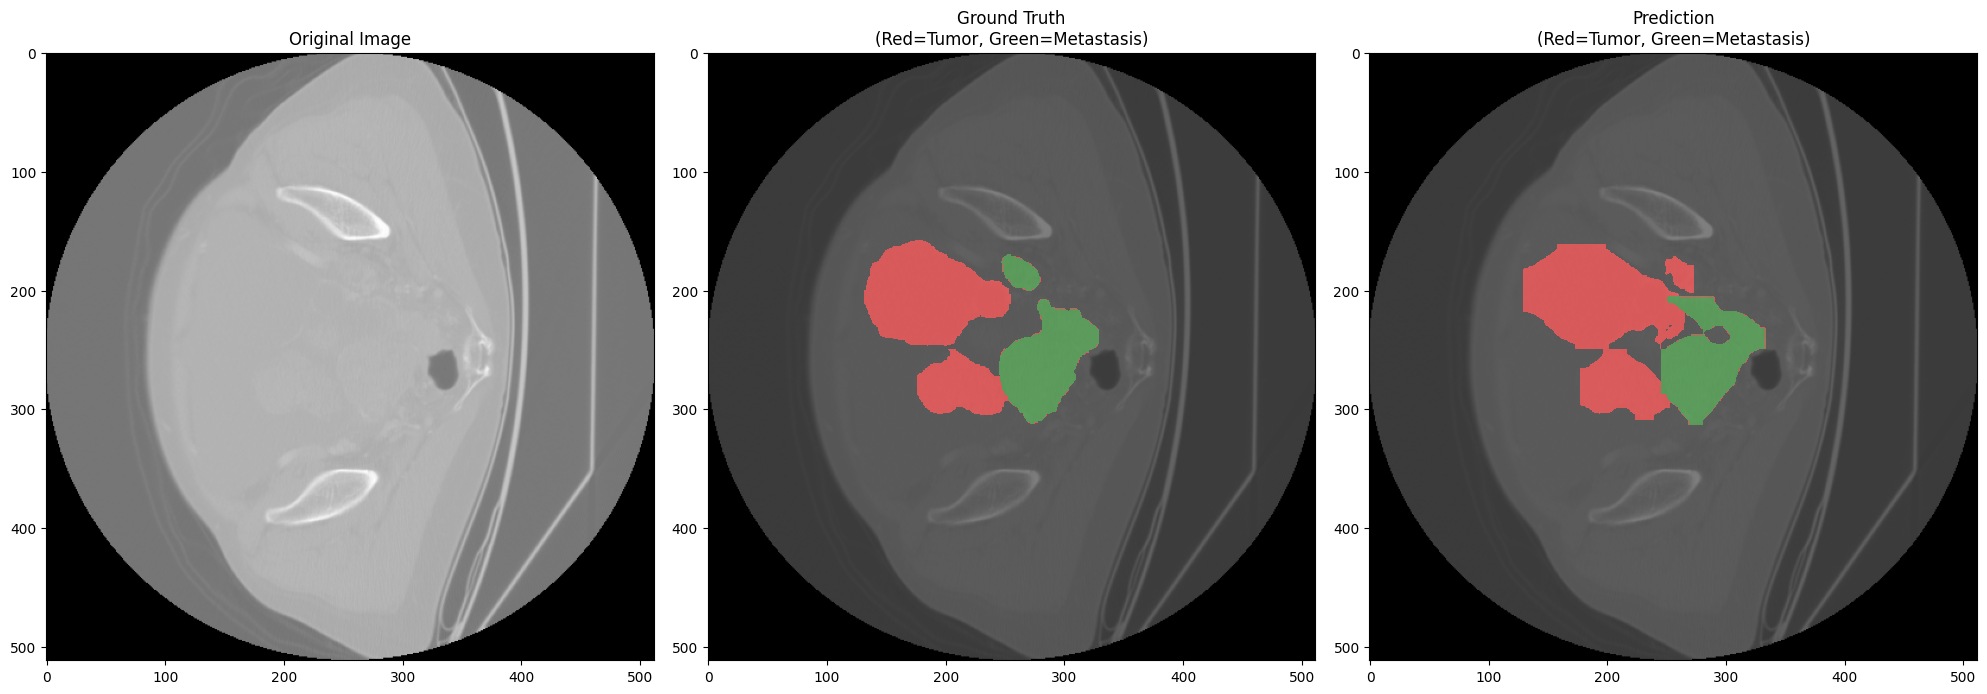

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Load model and image
test_img_path = "/kaggle/input/dataset/dataset/images/test/TCGA-09-0367_slice_017.png"
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Initialize masks
gt_mask = np.zeros((h, w), dtype=np.uint8)
pred_mask = np.zeros((h, w), dtype=np.uint8)

# =====================
# 1. Process Ground Truth
# =====================
gt_mask_path = "/kaggle/input/dataset/dataset/labels/test/TCGA-09-0367_slice_017.txt"
class_colors = {0: 1, 1: 2}  # Class 0=Tumor (Red), 1=Metastasis (Green)

with open(gt_mask_path) as f:
    for line in f:
        parts = list(map(float, line.strip().split()))
        class_id = int(parts[0])
        points = np.array([(x*w, y*h) for x,y in zip(parts[1::2], parts[2::2])], np.int32)
        cv2.fillPoly(gt_mask, [points], color=class_colors[class_id])

# =====================
# 2. Process Predictions
# =====================
results = model.predict(test_img_path)

# Combine all predictions of same class
for mask_data, class_id in zip(results[0].masks.data.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
    class_id = int(class_id)
    obj_mask = (mask_data > 0.5).astype(np.uint8)
    pred_mask[obj_mask == 1] = class_colors.get(class_id, 0)  # Use same colors as Ground Truth

# =====================
# 3. Visualization
# =====================
plt.figure(figsize=(20, 10))

# Create custom colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red', 'green'])  # 0=black, 1=red, 2=green

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

# Ground Truth (All objects)
plt.subplot(1, 3, 2)
plt.imshow(img)
plt.imshow(gt_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=2)
plt.title(f"Ground Truth\n(Red=Tumor, Green=Metastasis)")

# Prediction (All objects)
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(pred_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=2)
plt.title(f"Prediction\n(Red=Tumor, Green=Metastasis)")

plt.tight_layout()
# Save the figure
plt.savefig('/kaggle/working/prediction.png', dpi=300, bbox_inches='tight')  # Saves as PNG
plt.show()

In [ ]:
# Load model and image
test_img_path = "/kaggle/input/dataset/dataset/images/test/TCGA-09-0367_slice_062.png"
img = cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

# Initialize masks
gt_mask = np.zeros((h, w), dtype=np.uint8)
pred_mask = np.zeros((h, w), dtype=np.uint8)

# =====================
# 1. Process Ground Truth
# =====================
gt_mask_path = "/kaggle/input/dataset/dataset/labels/test/TCGA-09-0367_slice_062.txt"
class_colors = {0: 1, 1: 2}  # Class 0=Tumor (Red), 1=Metastasis (Green)

with open(gt_mask_path) as f:
    for line in f:
        parts = list(map(float, line.strip().split()))
        class_id = int(parts[0])
        points = np.array([(x*w, y*h) for x,y in zip(parts[1::2], parts[2::2])], np.int32)
        cv2.fillPoly(gt_mask, [points], color=class_colors[class_id])

# =====================
# 2. Process Predictions
# =====================
results = model.predict(test_img_path, show= True)

# Combine all predictions of same class
for mask_data, class_id in zip(results[0].masks.data.cpu().numpy(), results[0].boxes.cls.cpu().numpy()):
    class_id = int(class_id)
    obj_mask = (mask_data > 0.5).astype(np.uint8)
    pred_mask[obj_mask == 1] = class_colors.get(class_id, 0)  # Use same colors as Ground Truth

# =====================
# 3. Visualization
# =====================
plt.figure(figsize=(20, 10))

# Create custom colormap
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['black', 'red', 'green'])  # 0=black, 1=red, 2=green

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

# Ground Truth (All objects)
plt.subplot(1, 3, 2)
plt.imshow(img)
plt.imshow(gt_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=2)
plt.title(f"Ground Truth\n(Red=Tumor, Green=Metastasis)")

# Prediction (All objects)
plt.subplot(1, 3, 3)
plt.imshow(img)
plt.imshow(pred_mask, cmap=cmap, alpha=0.5, vmin=0, vmax=2)
plt.title(f"Prediction\n(Red=Tumor, Green=Metastasis)")

plt.tight_layout()
# Save the figure
plt.savefig('/kaggle/working/prediction1.png', dpi=300, bbox_inches='tight')  # Saves as PNG
plt.show()